In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# import xgboost as xgb
from itertools import tee, islice
from ROOT import TFile, TCanvas, TPad, TPaveLabel, TPaveText, TTree, TH1F, TF1
from root_numpy import root2array, tree2array, array2tree, array2root
import sys
from ROOT import gROOT, AddressOf
from root_numpy import root2array, rec2array


from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

Welcome to JupyROOT 6.22/02


In [2]:
back = 'back.root'
signal = 'signal.root'
# out_dir = '/afs/cern.ch/user/s/sraj/public/plot'
treeName_back = "tagsDumper/trees/thq_125_13TeV_THQLeptonicTag"
treeName_signal = "tagsDumper/trees/tth_125_13TeV_THQLeptonicTag"
columns = ['dipho_pt','dipho_phi','dipho_eta','dipho_e','dipho_mass','dipho_leadPt','dipho_leadEt','dipho_leadEta','dipho_leadPhi','dipho_subleadEta','bjet1_pt',
          'bjet2_pt','bjet1_eta','bjet2_eta','jet1_pt','jet2_pt','jet1_eta','n_jets']

columns = [c.strip() for c in columns]
columns = (b.replace(" ", "_") for b in columns)
columns = list(b.replace("-", "_") for b in columns)

mc_arr = root2array(back, treeName_back, columns)
data_arr = root2array(signal, treeName_signal, columns)

signal = rec2array(data_arr)
backgr = rec2array(mc_arr)

In [3]:
# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples
X = np.concatenate((signal, backgr))
y = np.concatenate((np.ones(signal.shape[0]),
                    np.zeros(backgr.shape[0])))

In [4]:
# Create a pandas DataFrame for our data
# this provides many convenience functions
# for exploring your dataset
# need to reshape y so it is a 2D array with one column
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                  columns=columns+['y'])

In [5]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=380)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf


In [9]:
#define model for training
regr_2 = Sequential()
regr_2.add(Dense(300, activation= 'relu', input_shape = (18,)))
# regr_2.add(Dense(300, activation= 'relu'))
# regr_2.add(Dense(300, activation= 'relu'))
# regr_2.add(Dense(300,activation= 'relu'))
# regr_2.add(Dense(300,activation= 'relu'))
regr_2.add(Dense(1, activation= 'sigmoid'))

regr_2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
# model.summary()

In [10]:
regr_2.fit(X_train, y_train, epochs = 30, batch_size= 900, validation_split = 0.25)

Epoch 1/30
162/162 [==============================] - 39s 19ms/step - loss: 2.2934 - accuracy: 0.7211 - val_loss: 1.1898 - val_accuracy: 0.7968
Epoch 2/30
162/162 [==============================] - 2s 9ms/step - loss: 0.8890 - accuracy: 0.7411 - val_loss: 0.4643 - val_accuracy: 0.7990
Epoch 3/30
162/162 [==============================] - 2s 9ms/step - loss: 0.6003 - accuracy: 0.7795 - val_loss: 0.4936 - val_accuracy: 0.8031
Epoch 4/30
162/162 [==============================] - 2s 9ms/step - loss: 0.7263 - accuracy: 0.7689 - val_loss: 0.5322 - val_accuracy: 0.7843
Epoch 5/30
162/162 [==============================] - 2s 10ms/step - loss: 0.5948 - accuracy: 0.7779 - val_loss: 0.5960 - val_accuracy: 0.7974
Epoch 6/30
162/162 [==============================] - 2s 10ms/step - loss: 0.5863 - accuracy: 0.7796 - val_loss: 0.4446 - val_accuracy: 0.8143
Epoch 7/30
162/162 [==============================] - 2s 13ms/step - loss: 0.5072 - accuracy: 0.8052 - val_loss: 0.4911 - val_accuracy: 0.7953
E

2021-09-14 16:46:20.406494: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-14 16:46:20.479523: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


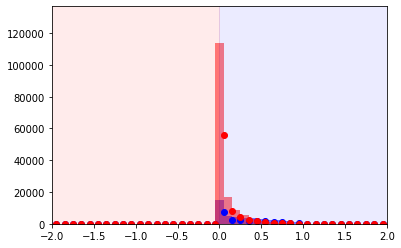

In [11]:
def construct_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions =[]
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.predict(X_train[y_train>0.5]).ravel()
        d2 = clf.predict(X_train[y_train<0.5]).ravel()
        d3 = clf.predict(X_test[y_test>0.5]).ravel()
        d4 = clf.predict(X_test[y_test<0.5]).ravel()
        
    c_max = 2.0
    c_min = -2.0
    
    # Get histogram of the classifiers
    Histo_training_S = np.histogram(d1,bins=40,range=(c_min,c_max))
    Histo_training_B = np.histogram(d2,bins=40,range=(c_min,c_max))
    Histo_testing_S = np.histogram(d3,bins=40,range=(c_min,c_max))
    Histo_testing_B = np.histogram(d4,bins=40,range=(c_min,c_max))
    
    # Lets get the min/max of the Histograms
    AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
    h_max = max([histo[0].max() for histo in AllHistos])*1.2
    h_min = max([histo[0].min() for histo in AllHistos])
    
    # Get the histogram properties (binning, widths, centers)
    bin_edges = Histo_training_S[1]
    bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
    bin_widths = (bin_edges[1:] - bin_edges[:-1])
    
    # To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
    ErrorBar_testing_S = np.sqrt(Histo_testing_S[0])
    ErrorBar_testing_B = np.sqrt(Histo_testing_B[0])

    # Draw objects
    ax1 = plt.subplot(111)
 
    # Draw solid histograms for the training data
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
 
    # # Draw error-bar histograms for the testing data
    ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
    ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
 
    # Make a colorful backdrop to show the clasification regions in red and blue
    ax1.axvspan(0.0, c_max, color='blue',alpha=0.08)
    ax1.axvspan(c_min,0.0, color='red',alpha=0.08)
 
    # Adjust the axis boundaries (just cosmetic)
    ax1.axis([c_min, c_max, h_min, h_max])   
        
construct_train_test(regr_2, X_train, y_train, X_test, y_test)    



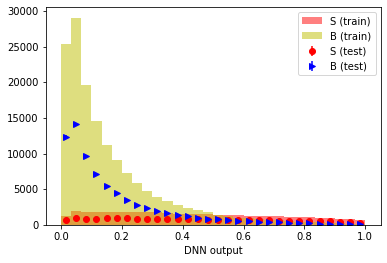

In [14]:
# For DNN again the overtraining check 
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.predict(X[y>0.5]).ravel()
        d2 = clf.predict(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
     
    ax1 = plt.subplot(111)

    
    ax1.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled',
             label='S (train)')
    ax1.hist(decisions[1],
             color='y', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled',
             label='B (train)')
    
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high,)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    ax1.errorbar(center, hist, yerr=err, fmt='>', c='b', label='B (test)')

    plt.xlabel("DNN output")
    plt.ylabel("")
    plt.legend(loc='best')
    
compare_train_test(regr_2, X_train, y_train, X_test, y_test)    


In [ ]:
# ROC curve
from sklearn.metrics import roc_curve, auc

decisions = regr_2.predict(X_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
# plt.savefig("ROC_curve_with_18_variables.png")
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.svm import SVC
from sklearn import tree


In [ ]:
#Adaboost
regr_2 = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=1),
                          n_estimators=100, random_state=1,learning_rate=0.5)

regr_2.fit(X_train, y_train)

In [ ]:
def construct_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions =[]
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.predict(X_train[y_train>0.5]).ravel()
        d2 = clf.predict(X_train[y_train<0.5]).ravel() 
        d3 = clf.predict(X_test[y_test>0.5]).ravel()
        d4 = clf.predict(X_test[y_test<0.5]).ravel()
#         d1 = clf.predict(X_train[y_train>0.5]).ravel()
#         d2 = clf.predict(X_train[y_train<0.5]).ravel()
#         d3 = clf.predict(X_test[y_test>0.5]).ravel()
#         d4 = clf.predict(X_test[y_test<0.5]).ravel()
        
    c_max = 2.0
    c_min = -2.0
    
    # Get histogram of the classifiers
    Histo_training_S = np.histogram(d1,bins=40,range=(c_min,c_max))
    Histo_training_B = np.histogram(d2,bins=40,range=(c_min,c_max))
    Histo_testing_S = np.histogram(d3,bins=40,range=(c_min,c_max))
    Histo_testing_B = np.histogram(d4,bins=40,range=(c_min,c_max))
    
    # Lets get the min/max of the Histograms
    AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
    h_max = max([histo[0].max() for histo in AllHistos])*1.2
    h_min = max([histo[0].min() for histo in AllHistos])
    
    # Get the histogram properties (binning, widths, centers)
    bin_edges = Histo_training_S[1]
    bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
    bin_widths = (bin_edges[1:] - bin_edges[:-1])
    
    # To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
    ErrorBar_testing_S = np.sqrt(Histo_testing_S[0])
    ErrorBar_testing_B = np.sqrt(Histo_testing_B[0])

    # Draw objects
    ax1 = plt.subplot(111)
 
    # Draw solid histograms for the training data
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
 
    # # Draw error-bar histograms for the testing data
    ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
    ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
 
    # Make a colorful backdrop to show the clasification regions in red and blue
    ax1.axvspan(0.0, c_max, color='blue',alpha=0.08)
    ax1.axvspan(c_min,0.0, color='red',alpha=0.08)
 
    # Adjust the axis boundaries (just cosmetic)
    ax1.axis([c_min, c_max, h_min, h_max])   
        
construct_train_test(regr_2, X_train, y_train, X_test, y_test)    



In [ ]:
##AfterDNN fitting try this code
def construct_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
#     decisions =[]
#     for X,y in ((X_train, y_train), (X_test, y_test)):
    d1 = clf.predict(X_train[y_train>0.5]).ravel()
    d2 = clf.predict(X_train[y_train<0.5]).ravel()
    d3 = clf.predict(X_test[y_test>0.5]).ravel()
    d4 = clf.predict(X_test[y_test<0.5]).ravel()
        
    c_max = 2.0
    c_min = -2.0
    
    # Get histogram of the classifiers
    Histo_training_S = np.histogram(d1,bins=40,range=(c_min,c_max))
    Histo_training_B = np.histogram(d2,bins=40,range=(c_min,c_max))
    Histo_testing_S = np.histogram(d3,bins=40,range=(c_min,c_max))
    Histo_testing_B = np.histogram(d4,bins=40,range=(c_min,c_max))
    
    # Lets get the min/max of the Histograms
    AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
    h_max = max([histo[0].max() for histo in AllHistos])*1.2
    h_min = max([histo[0].min() for histo in AllHistos])
    
    # Get the histogram properties (binning, widths, centers)
    bin_edges = Histo_training_S[1]
    bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
    bin_widths = (bin_edges[1:] - bin_edges[:-1])
    
    # To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
    ErrorBar_testing_S = np.sqrt(Histo_testing_S[0])
    ErrorBar_testing_B = np.sqrt(Histo_testing_B[0])

    # Draw objects
    ax1 = plt.subplot(111)
 
    # Draw solid histograms for the training data
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
 
    # # Draw error-bar histograms for the testing data
    ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
    ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
 
    # Make a colorful backdrop to show the clasification regions in red and blue
    ax1.axvspan(0.0, c_max, color='blue',alpha=0.08)
    ax1.axvspan(c_min,0.0, color='red',alpha=0.08)
 
    # Adjust the axis boundaries (just cosmetic)
    ax1.axis([c_min, c_max, h_min, h_max])   
        
construct_train_test(regr_2, X_train, y_train, X_test, y_test)    



In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier



In [18]:
##BDT
bdt = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.5,
    min_samples_leaf=int(0.05*len(X_train)),
    max_depth=3, random_state=0)

In [ ]:
bdt.fit(X_train, y_train)


In [ ]:
# For DNN again the overtraining check 
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.predict(X[y>0.5]).ravel()
        d2 = clf.predict(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
     
    ax1 = plt.subplot(111)

    
    ax1.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled',
             label='S (train)')
    ax1.hist(decisions[1],
             color='y', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled',
             label='B (train)')
    
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high,)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    ax1.errorbar(center, hist, yerr=err, fmt='>', c='b', label='B (test)')

    plt.xlabel("DNN output")
    plt.ylabel("")
    plt.legend(loc='best')
    
compare_train_test(b, X_train, y_train, X_test, y_test)    
